### Stochastic Distance Non Local Means Filter

In [1]:
import rasterio as rio
import numpy as np
from scipy.stats import gamma,chi2
from tqdm import tqdm

In [2]:
def fit_gamma(patch, nodata = -9999): 
    # Fit the Gamma distribution
    dados_validos = patch[patch != nodata]
    
    if dados_validos.size == 0:
        raise ValueError("Nenhum dado válido após remoção de 'NoData'")
    
    shape, loc, scale = gamma.fit(dados_validos, floc=0)  # floc=0 to fix location to 0
    rate = 1 / scale  # Rate is the inverse of the scale parameter
    return shape, rate

In [3]:
def kl_divergence_gamma(shape1, rate1, shape2, rate2, size1, size2):
    # Calcular a métrica de Kullback-Leibler adaptada para distribuições gamma
    # usando os parâmetros das distribuições e os tamanhos das amostras
    m, n = size1, size2
    L1, Li = rate1, rate2
    λ1, λi = shape1, shape2
    s_KL = (m * n / (m + n)) * (L1 + Li) * ((λ1**2 + λi**2) / (2 * λ1 * λi) - 1)
    return s_KL


In [4]:
def gamma_kl_test(kl_values, alpha, degrees_of_freedom):
    # η é o nível de significância efetivo calculado a partir do α fornecido e dos graus de liberdade
    eta = 1 - (1 - alpha)**(1 / 8)
    
    # Calcular o valor crítico para o nível de significância efetivo
    critical_value = chi2.ppf(1 - eta, df=degrees_of_freedom)
    
    # Testar cada divergência
    results = []
    for kl in kl_values:
        if kl > critical_value:
            results.append((kl, 0)) # Rejeitar H0
        else:
            results.append((kl, 1)) # Não rejeitar H0
    
    return results, critical_value

In [8]:
def stcd_nlm_filter(imagem): #Filtro de médias não-locais por distâncias estocásticas que utiliza a vizinhança de Nagao e Matsuyama (1979)

  # Verificando tamanho e largura da imagem e criando imagem de saída para filtragem
  # out é definido como uma imagem de zeros com quatro linhas e colunas a menos
  height, width = imagem.shape
  out = np.zeros((height, width), dtype=float)
  # out[2: 2 + height, 2: 2 + width] = imagem.copy().astype(float)

  # Criação dos 8 patches de pixels da vizinhança de Nagao-Matsuyama
  qtd_iteracoes = 0
  for i in tqdm(range(2, height - 2), desc="Processando linhas", unit="pixel"):
      for j in range(2, width -2):
        patch1 = np.ravel(imagem[i - 1:i + 2, j+1:j + 3]) #right
        patch1 = np.append(patch1, imagem[i, j])
        
        patch2 = np.ravel(imagem[i + 1:i + 3, j-1:j + 2]) #bottom
        patch2 = np.append(patch2, imagem[i, j])
        
        patch3 = np.ravel(imagem[i - 1:i + 2, j -2:j]) #left
        patch3 = np.append(patch3, imagem[i, j])
        
        patch4 = np.ravel(imagem[i-2:i, j-1:j + 2]) # top 
        patch4 = np.append(patch4, imagem[i, j])
        
        patch5 = np.ravel(imagem[i-2:i, j+1:j + 3]) #right-top
        patch5 = np.append(patch5, [imagem[i, j], imagem[i -1, j], imagem[i, j + 1]])
        
        patch6 = np.ravel(imagem[i + 1:i + 3, j+1:j + 3]) #right-bottom
        patch6 = np.append(patch6, [imagem[i, j], imagem[i, j+1], imagem[i+1, j]])
        
        patch7 = np.ravel(imagem[i + 1:i + 3, j - 2:j]) #left-bottom
        patch7 = np.append(patch7, [imagem[i, j], imagem[i + 1, j], imagem[i, j-1]])
        
        patch8 = np.ravel(imagem[i-2:i, j-2:j]) #left-top
        patch8 = np.append(patch8, [imagem[i, j], imagem[i, j -1], imagem[i-1, j]])
        
        patch0 = np.ravel(imagem[i - 1:i + 2, j - 1:j + 2])# Vizinhança de nagao-matsuyama modificada com patch central
        
        
        # Cálculo da similaridade dos pacthes com o patch central  
        patches = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]
    
        size0 = len(patch0)
        shape0, rate0 = fit_gamma(patch0)
        kl_metrics = []
        

        for patch in patches: 
            shape, rate = fit_gamma(patch)
            size = len(patch)
            
            kl_div = kl_divergence_gamma(shape0, rate0, shape, rate, size0, size)
            kl_metrics.append(kl_div)
            
            alpha = 0.05  # Nível de significância desejado
            degrees_of_freedom = 2  # Graus de liberdade para o teste de qui-quadrado
            
            test_results, critical_value = gamma_kl_test(kl_metrics, alpha, degrees_of_freedom)
            
            # Filtro para resultados que rejeitaram H0
            passed_tests = [result for result in test_results if result[1] == 1]
            
            if passed_tests:
            # Selecionar o patch com a maior margem positiva (mais folga)
                best_patch = max((result for result in test_results if result[1] == 1), # Filtrar apenas os resultados onde H0 não foi rejeitado
        key=lambda x: critical_value - x[0], # Escolher o patch com a maior folga
        default=None)
                patch_index = test_results.index(best_patch)
                selected_patch = patches[patch_index]
                combined_pixels = np.union1d(patch0, selected_patch)
            else:
                combined_pixels = patch0
        
        out[i,j] = np.mean(combined_pixels)
        qtd_iteracoes += 1
        percentual = 100 * qtd_iteracoes / (height * width)

        # Formatando a porcentagem com duas casas decimais usando f-string
        # print(f"{percentual:.2f}%")

  return out

In [6]:
def check_image_bands_for_negatives(image):
    """
    Verifica se há valores negativos em cada banda de uma imagem.
    
    Parâmetros:
    - image: numpy array 3D (altura, largura, bandas)
    
    Retorna:
    - Um dicionário contendo o resultado para cada banda.
    """
    num_bands = image.shape[2]  # Número de bandas
    result = {}
    
    for band in range(num_bands):
        # Extrai a banda específica
        band_data = image[:, :, band]
        
        # Verifica se há valores negativos na banda
        has_negatives = np.any(band_data < 0)
        
        # Armazena o resultado no dicionário
        result[f"Banda {band+1}"] = has_negatives
    
    return result

In [17]:
def calcular_estatisticas_bandas(imagem):
    """
    Calcula estatísticas básicas para cada banda de uma imagem (mínimo, máximo, média, desvio padrão).
    
    Parâmetros:
    - imagem: Array NumPy 3D (altura, largura, bandas)
    
    Retorna:
    - estatisticas: Um dicionário contendo as estatísticas para cada banda.
    """
    num_bandas = imagem.shape[2]  # Número de bandas
    estatisticas = {}
    
    for banda in range(num_bandas):
        # Extrai a banda específica
        banda_data = imagem[:, :, banda]
        
        # Calcula as estatísticas
        min_val = np.min(banda_data)
        max_val = np.max(banda_data)
        mean_val = np.mean(banda_data)
        std_val = np.std(banda_data)
        
        # Armazena as estatísticas no dicionário
        estatisticas[f"Banda {banda+1}"] = {
            'Min': min_val,
            'Max': max_val,
            'Média': mean_val,
            'Desvio Padrão': std_val
        }
    
    return estatisticas

In [7]:
path = "G:/Meu Drive/UNIFESP/forest_eyes/4.imagens/imagens_processadas/data_sbsr/sentinel1_mosaic_30m_REC.TIF"
with rio.open(path) as src:
    # Ler todas as bandas da imagem e empilhá-las em um array NumPy
    imagem = src.read()  # A saída será um array com a forma (bandas, altura, largura)
    
    # Transpor o array para a forma (altura, largura, bandas)
    imagem = np.transpose(imagem, (1, 2, 0))

In [16]:
resultados = check_image_bands_for_negatives(imagem)
for banda, tem_negativos in resultados.items():
    print(f"{banda}: {'Tem valores negativos' if tem_negativos else 'Sem valores negativos'}")

Banda 1: Tem valores negativos
Banda 2: Tem valores negativos


In [18]:
estatisticas_bandas = calcular_estatisticas_bandas(imagem)

# Exibir as estatísticas de cada banda
for banda, stats in estatisticas_bandas.items():
    print(f"{banda}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name}: {stat_value:.4f}")

Banda 1:
  Min: -9999.0000
  Max: 1.6696
  Média: -27.5202
  Desvio Padrão: 529.2330
Banda 2:
  Min: -9999.0000
  Max: 0.9006
  Média: -27.7911
  Desvio Padrão: 529.2186


In [ ]:
image_array = np.random.randint(1, 256, size=(1000, 800))  # Valores entre 0 e 255, típicos para uma imagem em escala de cinza
image_array
out = stcd_nlm_filter(image_array)

In [9]:
# Mude este path, pelo caminho da imagem a ser filtrada
dataset = rio.open("G:/Meu Drive/UNIFESP/forest_eyes/4.imagens/imagens_processadas/data_sbsr/ALOS_S05W054_2022_HH_HV_reproj_corr_cal_stack_REC.TIF", mode='r')

In [10]:
name = 'ALOS_PALSAR'
out_path = "G:/Meu Drive/UNIFESP/forest_eyes/4.imagens/imagens_processadas/data_sbsr"
filtered_images = []
for i in dataset.indexes:
  print(f'>>> Iniciando filtragem da banda {i}...')
  out = stcd_nlm_filter(dataset.read(i)) # Chamada da função dentro do loop.
  height, width = dataset.shape
  out = out[2:2 + height, 2:2 + width]# redimensionando as imagens para o mesmo tamanho.
  filtered_images.append(out)  # Armazenar banda filtrada
  print(f'>>> Banda {i} filtrada!! \n')

# Converter lista de bandas filtradas para um array numpy com dimensões (bandas, altura, largura)
stacked_image = np.stack(filtered_images)

# Exportar o stack de bandas filtradas
tiff_name = f'{out_path}/{name}_stack_stcd.TIF'

# Abrir um novo arquivo GeoTIFF com o número correto de bandas
with rio.open(tiff_name,
              'w',
              driver='GTiff',
              height=stacked_image.shape[1],
              width=stacked_image.shape[2],
              count=len(dataset.indexes),  # número de bandas
              dtype=stacked_image.dtype,
              crs=dataset.crs,
              nodata=None,  # Ajuste se necessário
              transform=dataset.transform) as dst:

    # Escrever cada banda no arquivo
    for i in range(stacked_image.shape[0]):
        dst.write(stacked_image[i], i + 1)
print(">>> Fim da filtragem!")

>>> Iniciando filtragem da banda 1...


Processando linhas: 100%|██████████| 839/839 [29:55<00:00,  2.14s/pixel]


>>> Banda 1 filtrada!! 

>>> Iniciando filtragem da banda 2...


Processando linhas: 100%|██████████| 839/839 [29:35<00:00,  2.12s/pixel]


>>> Banda 2 filtrada!! 

>>> Fim da filtragem!


### Testes Unitários

In [6]:
# fit_gama

# Gerar dados de um patch simulado que segue uma distribuição Gamma
np.random.seed(42)  # Para reprodutibilidade
shape_true = 5  # Parâmetro shape verdadeiro
rate_true = 0.5  # Parâmetro rate verdadeiro
size = 100  # Número de observações

# Criar dados do patch
patch = gamma.rvs(shape_true, scale=1/rate_true, size=size)

# Usar a função fit_gamma para estimar os parâmetros
shape_estimated, rate_estimated = fit_gamma(patch)

# Mostrar os resultados
print(f"Parâmetros verdadeiros: shape = {shape_true}, rate = {rate_true}")
print(f"Parâmetros estimados: shape = {shape_estimated:.4f}, rate = {rate_estimated:.4f}")

Parâmetros verdadeiros: shape = 5, rate = 0.5
Parâmetros estimados: shape = 6.8790, rate = 0.6979


In [15]:
# teste unitário
# divergencia

# Definir parâmetros para duas distribuições Gamma
shape1, rate1 = 5, 0.5  # Parâmetros para a primeira distribuição
shape2, rate2 = 3, 0.8  # Parâmetros para a segunda distribuição
size1, size2 = 9, 8 # Tamanhos das amostras

# Calcular a divergência KL entre as duas distribuições
kl_divergence = kl_divergence_gamma(shape1, rate1, shape2, rate2, size1, size2)

# Mostrar o resultado
print(f"A divergência KL entre as duas distribuições é: {kl_divergence:.4f}")

A divergência KL entre as duas distribuições é: 0.7341


In [20]:
# Valores de KL simulados
kl_values = [5, 10, 3, 7, 12, 1, 8]

# Nível de significância desejado
alpha = 0.05

# Graus de liberdade para o teste de qui-quadrado
degrees_of_freedom = 2

# Executando o teste
test_results = gamma_kl_test(kl_values, alpha, degrees_of_freedom)

# Mostrar os resultados e o valor crítico
print("Resultados do Teste:")
for result in test_results:
    print(f"KL = {result[0]:.2f}, Decisão: {result[1]}")
print(f"Valor crítico: {critical_value:.4f}")

Resultados do Teste:
KL = 5.00, Decisão: Não rejeitar H0
KL = 10.00, Decisão: Não rejeitar H0
KL = 3.00, Decisão: Não rejeitar H0
KL = 7.00, Decisão: Não rejeitar H0
KL = 12.00, Decisão: Rejeitar H0
KL = 1.00, Decisão: Não rejeitar H0
KL = 8.00, Decisão: Não rejeitar H0
Valor crítico: 10.1057


In [59]:
kl_div = kl_divergence_gamma(shape0, rate0, shape, rate, size0, size)
kl_metrics.append(kl_div)

In [61]:
alpha = 0.05  # Nível de significância desejado
degrees_of_freedom = 2  # Graus de liberdade para o teste de qui-quadrado

test_results = gamma_kl_test(kl_metrics, alpha, degrees_of_freedom)
test_results

[(0.008225715887850255, 1)]

In [ ]:
# Filtro para resultados que rejeitaram H0
passed_tests = [result for result in test_results if result[1] == 1]

if passed_tests:
# Selecionar o patch com a maior margem positiva (mais folga)
    most_favorable_patch = max(passed_tests, key=lambda x: x[2])
    patch_index = test_results.index(most_favorable_patch)
    selected_patch = patches[patch_index]
    combined_pixels = np.union1d(patch0, selected_patch)
else:
    combined_pixels = patch0

out[2 + i, 2 + j] = np.mean(combined_pixels)
qtd_iteracoes += 1


### Visualizando as imagens

In [5]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show


Altura: 1026, Largura: 1498
Contagem de bandas: 1
Transformação affine: | 24.61, 0.00, 203639.80|
| 0.00,-24.61, 9384185.56|
| 0.00, 0.00, 1.00|


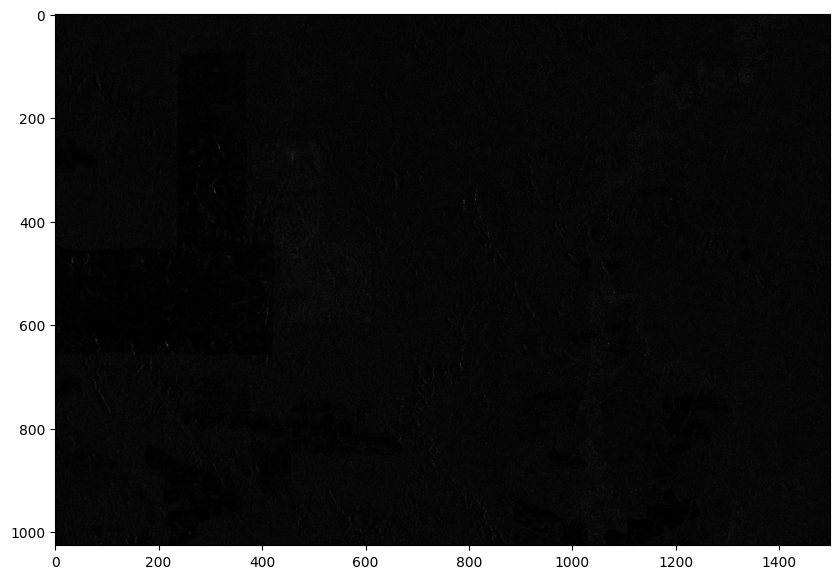

: 

In [7]:
dataset = "G:/Meu Drive/UNIFESP/forest_eyes/4.imagens/imagens_processadas/ALOS_S05W054_2022_HH_reproj_rec_cal.tif"

# Abrindo o raster
with rio.open(dataset) as src:
    # Ler a primeira banda do raster
    image = src.read(1)
    
    # Exibir metadados do raster
    print(f"Altura: {src.height}, Largura: {src.width}")
    print(f"Contagem de bandas: {src.count}")
    print(f"Transformação affine: {src.transform}")
    
    # Plotar o raster
    plt.figure(figsize=(10, 8))
    show(image, cmap='gray')